In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
from glob import glob
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Importing Data

In [75]:
raw_data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
print(raw_data.shape)

(1050, 15)


In [102]:
def extract_category(df):
    df["category"] = df["product_category_tree"].apply(
        lambda category_tree: category_tree.split(" >>")[0].replace('["', "")
    )

    return df

data = extract_category(raw_data)

le = preprocessing.LabelEncoder()
le.fit(data["category"])
data["encoded_category"] = le.transform(data["category"])

In [77]:
path = "data/Images/"

image_data = data[["category","encoded_category", "image"]]
categories = image_data["category"].unique()
image_data

,category,encoded_category,image
0,Home Furnishing,4,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,0,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,0,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,4,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,4,6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...,...
1045,Baby Care,0,958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,Baby Care,0,fd6cbcc22efb6b761bd564c28928483c.jpg
1047,Baby Care,0,5912e037d12774bb73a2048f35a00009.jpg
1048,Baby Care,0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


# Supervised Classification

## Creating initial classification model

Building the model that will be used for the supervised learning. 

We initialize a VGG16 pre-trained model, to which we will add layers that are specific to our data set.

In [78]:
def build_model() :
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [79]:
data, test_data, y_train, y_test = train_test_split(
    image_data[["encoded_category", "image"]], image_data["category"], test_size=0.2
)

Preprocessing the images to fit the model's requirements

In [80]:
def image_preprocessing(data) :
    prepared_images = []
    for image in data['image'] :
        img = (load_img(path + image, target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    return np.array(prepared_images)


Separating our images into two sets, one used for training and validation and the other one for testing purposes

In [81]:
images = image_preprocessing(data)
print(images.shape)
test_images = image_preprocessing(test_data)
print(test_images.shape)

/Users/amelie-dzovinar/Dev/anaconda3/envs/p6/lib/python3.11/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


In [82]:
X = images
y = to_categorical(data['encoded_category'])

X_test = test_images
y_test = to_categorical(test_data['encoded_category'])

y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

Separating the training data subset into train and validation data sets

In [83]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

Defining the model's monitoring parameters. 

We will be monitoring validation loss and stop training if there is no decrease of the validation loss after 5 epochs.

The validation loss is used to assess the model's performance on the validation data and is calculated from a sum of the errors for each example in the validation set.

In [84]:
with tf.device('/gpu:0'): 
    first_model = build_model()

model_saving_file = "./first_model_best_weights.h5"
checkpoint = ModelCheckpoint(model_saving_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

We use the training data to train the model and the validation data to evaluate the model's performance based on the validation loss and validation accuracy 

In [85]:
with tf.device('/gpu:0'): 
    first_model_history = first_model.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 6.2773 - accuracy: 0.4254
Epoch 1: val_loss improved from inf to 1.62720, saving model to ./first_model_best_weights.h5
10/10 [==============================] - 82s 8s/step - loss: 6.2773 - accuracy: 0.4254 - val_loss: 1.6272 - val_accuracy: 0.7095
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.0822 - accuracy: 0.6810
Epoch 2: val_loss improved from 1.62720 to 1.34508, saving model to ./first_model_best_weights.h5
10/10 [==============================] - 79s 8s/step - loss: 2.0822 - accuracy: 0.6810 - val_loss: 1.3451 - val_accuracy: 0.7429
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.2962 - accuracy: 0.7571
Epoch 3: val_loss improved from 1.34508 to 1.13213, saving model to ./first_model_best_weights.h5
10/10 [==============================] - 75s 8s/step - loss: 1.2962 - accuracy: 0.7571 - val_loss: 1.1321 - val_accuracy: 0.7571
Epoch 4/50
10/10 [=======================

The model stopped improving after 7 runs

Score of the last epoch run :

In [86]:
loss, accuracy = first_model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
print()
loss, accuracy = first_model.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy: {:.4f}".format(accuracy))
print("Validation Loss: {:.4f}".format(loss))

20/20 [==============================] - 55s 3s/step - loss: 0.0060 - accuracy: 1.0000
Training Accuracy: 1.0000
Training Loss: 0.0060

7/7 [==============================] - 18s 3s/step - loss: 1.0029 - accuracy: 0.8333
Validation Accuracy: 0.8333
Validation Loss: 1.0029


Score of the optimal epoch run :


In [87]:
first_model.load_weights(model_saving_file)

loss, accuracy = first_model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
print("Validation Loss: {:.4f}".format(loss))

loss, accuracy = first_model.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))
print("Test Loss: {:.4f}".format(loss))


Validation Accuracy: 0.7905
Validation Loss: 0.9063
Test Accuracy: 0.7857
Test Loss: 1.0058


Plotting accuracy and loss values 

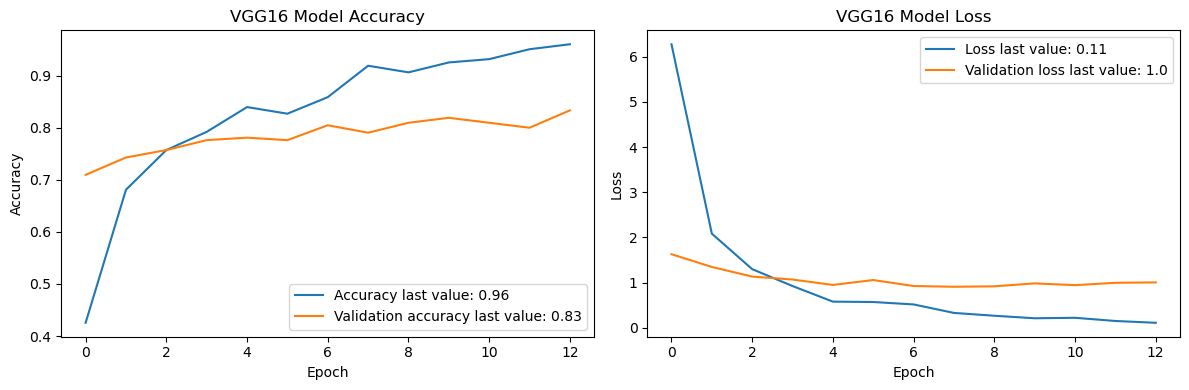

In [88]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(first_model_history.history["accuracy"])
plt.plot(first_model_history.history['val_accuracy'])
plt.title("VGG16 Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
accuracy = "Accuracy last value: " + str(round(first_model_history.history["accuracy"][-1], 2))
val_accuracy = "Validation accuracy last value: " + str(round(first_model_history.history["val_accuracy"][-1], 2))
plt.legend([accuracy, val_accuracy])

plt.subplot(1, 2, 2)
plt.plot(first_model_history.history['loss'])
plt.plot(first_model_history.history['val_loss'])
plt.title("VGG16 Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
loss = "Loss last value: " + str(round(first_model_history.history["loss"][-1], 2))
val_loss = "Validation loss last value: " + str(round(first_model_history.history["val_loss"][-1], 2))
plt.legend([loss, val_loss])

plt.tight_layout()
plt.show()


Creating confusion matrix

In [89]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(first_model.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 19s 3s/step
[3 6 2 6 3 5 4 0 0 2 6 0 1 5 6 3 1 1 6 0 1 2 6 3 3 0 4 4 2 0 2 4 6 5 1 6 4
 5 1 1 5 6 1 0 6 6 5 0 4 1 6 4 5 0 2 6 5 5 2 4 4 5 3 6 3 3 6 0 3 5 3 2 5 3
 3 3 2 6 2 5 4 4 2 0 3 5 2 5 3 4 3 4 6 1 2 5 0 4 6 4 5 1 1 5 3 1 1 1 2 2 3
 5 4 2 5 4 2 6 0 2 0 4 2 4 5 3 1 3 3 0 0 4 2 2 6 2 1 4 2 1 3 6 3 6 5 1 1 6
 6 0 0 5 3 4 3 3 5 1 4 2 4 5 6 5 0 4 0 6 1 0 4 0 2 1 5 0 2 4 0 5 2 4 1 1 0
 5 2 4 0 3 2 1 6 1 4 2 4 3 1 1 6 3 0 6 0 4 0 6 5 5]

[3 6 2 6 3 5 4 0 5 2 6 0 1 5 2 3 1 2 6 0 1 2 6 6 2 4 4 4 3 4 2 4 6 5 1 6 4
 5 1 1 5 6 5 3 6 6 5 5 2 1 6 0 5 0 2 6 5 5 2 4 4 5 3 6 3 3 6 0 3 5 3 2 5 3
 3 3 1 6 2 1 4 4 2 0 3 5 2 5 3 4 4 0 6 3 2 5 0 4 6 4 5 1 1 5 3 1 1 1 2 2 3
 5 4 2 5 0 2 6 0 2 0 0 2 4 5 2 1 3 3 0 2 4 2 2 6 0 3 4 2 1 1 6 3 6 2 1 2 2
 6 0 0 3 3 0 3 3 5 1 4 2 4 5 6 5 3 4 4 2 1 5 4 0 2 4 5 0 2 3 0 5 2 0 2 1 2
 5 5 4 0 3 2 1 6 3 4 2 4 3 1 1 6 4 4 6 0 4 0 5 5 5]


In [93]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[18  0  2  2  4  3  0]
 [ 0 21  3  3  1  1  0]
 [ 1  1 26  1  0  1  0]
 [ 0  1  2 23  2  0  1]
 [ 6  0  1  1 24  0  0]
 [ 0  1  1  1  0 28  0]
 [ 0  0  3  0  0  1 26]]


In [99]:
print(classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67        29
           1       0.88      0.72      0.79        29
           2       0.68      0.87      0.76        30
           3       0.74      0.79      0.77        29
           4       0.77      0.75      0.76        32
           5       0.82      0.90      0.86        31
           6       0.96      0.87      0.91        30

    accuracy                           0.79       210
   macro avg       0.80      0.79      0.79       210
weighted avg       0.80      0.79      0.79       210



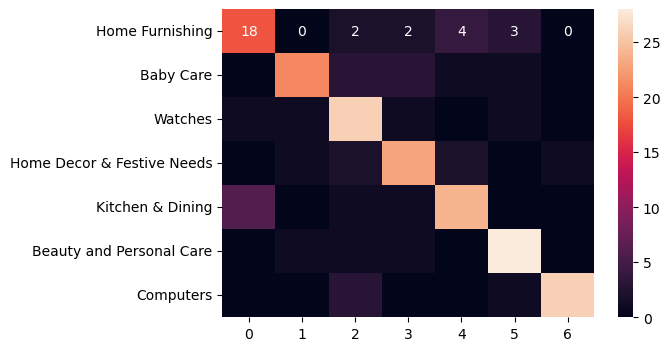

In [107]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in categories],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True)
plt.show()